In [1]:
!unzip flowers17.zip

Archive:  flowers17.zip
replace flowers17/bluebell/image_0241.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
!pip install keras_cv
!pip install keras_core

In [3]:
import imutils
import cv2


class AspectAwarePreprocessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        self.width = width
        self.height = height
        self.inter = inter

    def preprocess(self, image):
        (h, w) = image.shape[:2]
        dW = 0
        dH = 0

        # resize wrt shortest img dimension
        if w < h:
            image = imutils.resize(image, width=self.width, inter=self.inter)
            dH = int((image.shape[0] - self.height) / 2.0)
        else:
            image = imutils.resize(image, height=self.height, inter=self.inter)
            dW = int((image.shape[1] - self.width) / 2.0)

        # crop to achieve desired image size
        (h, w) = image.shape[:2]
        image = image[dH: h - dH, dW: w - dW]

        # resize again to ensure no rounding errors after cropping
        return cv2.resize(image, (self.width, self.height), interpolation=self.inter)


In [4]:
from keras.preprocessing.image import img_to_array


class ImageToArrayPreprocessor:
    def __init__(self, data_format=None):
        self.data_format = data_format

    def preprocess(self, image):
        return img_to_array(image, data_format=self.data_format)

In [5]:
import numpy as np
import cv2
import os


class SimpleDatasetLoader:
    def __init__(self, preprocessors=None):
        # store img preprocessor
        self.preprocessors = preprocessors

        if self.preprocessors is None:
            self.preprocessors = []

    def load(self, image_paths: list[str], verbose=-1) -> tuple[np.ndarray, np.ndarray]:
        data = []
        labels = []

        for (i, image_path) in enumerate(image_paths):
            # load img and extract class label assuming
            # path has following format:
            # /path/to/dataset/{class}/{image}.jpg
            image = cv2.imread(image_path)
            label = image_path.split(os.path.sep)[-2]

            if self.preprocessors is not None:
                for p in self.preprocessors:
                    image = p.preprocess(image)

                data.append(image)
                labels.append(label)

            if verbose > 0 and i > 0 and (i+1) % verbose == 0:
                print(f"[INFO] processed {i+1}/{len(image_paths)}")

        return np.array(data), np.array(labels)


In [6]:
from keras import Sequential
from keras_cv.layers import RandomFlip, RandomRotation, RandomTranslation, RandomZoom, RandomShear


class DataAugmentor:

    @staticmethod
    def build(model):
        data_augmentation = Sequential([
            RandomRotation(0.1),
            RandomTranslation(height_factor=0.1, width_factor=0.1),
            RandomShear(0.2),
            RandomZoom(0.2),
            RandomFlip("horizontal"),
        ])

        model = Sequential([data_augmentation, model])

        return model


Using TensorFlow backend


In [7]:
from keras.layers import Dropout, Flatten, Dense


class FCHeadNet:
    @staticmethod
    def build(baseModel, classes: int, D: int):
        headModel = baseModel.output
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(D, activation="relu")(headModel)
        headModel = Dropout(0.5)(headModel)

        headModel = Dense(classes, activation="softmax")(headModel)

        return headModel


In [8]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.optimizers import RMSprop, SGD
from keras.applications import VGG16
from keras.layers import Input
from keras.models import Model
from imutils import paths
import numpy as np
import argparse
import os

In [9]:
import matplotlib.pyplot as plt
from keras.models import Sequential
import numpy as np


def plot_training_loss_and_accuracy_keras(epoch_num: int, H: Sequential.fit, savefig_path=None):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, epoch_num), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epoch_num), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epoch_num), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epoch_num), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss / Accuracy")
    plt.legend()
    if savefig_path:
        plt.savefig(savefig_path)
    plt.show()

In [10]:
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset", required=True, help="path to input dataset")
ap.add_argument("-m", "--model", required=True, help="path to output model")
args = {}
args["dataset"] = "/content/flowers17"
args["model"] = "/content/flowers17.model"
print(args)

{'dataset': '/content/flowers17', 'model': '/content/flowers17.model'}


In [11]:
print("[INFO] loading images...")
image_paths = list(paths.list_images(args["dataset"]))
class_names = set([pt.split(os.path.sep)[-2] for pt in image_paths])

aap = AspectAwarePreprocessor(224, 224)
iap = ImageToArrayPreprocessor()

sdl = SimpleDatasetLoader(preprocessors=[aap, iap])
(data, labels) = sdl.load(image_paths, verbose=500)
data = data.astype("float") / 255.0

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)
trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)

base_model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
head_model = FCHeadNet.build(base_model, len(class_names), 256)
model = Model(inputs=base_model.input, outputs=head_model)

# this freezes the weights in the base model
for layer in base_model.layers:
    layer.trainable = False

# add data augmentation
model = DataAugmentor.build(model)

[INFO] loading images...
[INFO] processed 500/1360
[INFO] processed 1000/1360


In [12]:
print("[INFO] compiling the model...")
# small lr to warm up FC head
# always use lr that is multiple orders of magnitude smaller than orig learning rate
opt = RMSprop(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics="accuracy")

[INFO] compiling the model...


In [13]:
print("[INFO] training head...")
# warm-up phase ~ 10-30 epochs depending on dataset size
H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=32, epochs=25, verbose=1)

[INFO] training head...
Epoch 1/25
32/32 [==============================] - 25s 448ms/step - loss: 5.0034 - accuracy: 0.1657 - val_loss: 2.5530 - val_accuracy: 0.2206
Epoch 2/25
32/32 [==============================] - 7s 213ms/step - loss: 2.3497 - accuracy: 0.2657 - val_loss: 2.0020 - val_accuracy: 0.4206
Epoch 3/25
32/32 [==============================] - 5s 170ms/step - loss: 2.0216 - accuracy: 0.3520 - val_loss: 1.5017 - val_accuracy: 0.5412
Epoch 4/25
32/32 [==============================] - 7s 212ms/step - loss: 1.8020 - accuracy: 0.4000 - val_loss: 1.3882 - val_accuracy: 0.6412
Epoch 5/25
32/32 [==============================] - 5s 171ms/step - loss: 1.7407 - accuracy: 0.4186 - val_loss: 1.3546 - val_accuracy: 0.6471
Epoch 6/25
32/32 [==============================] - 7s 212ms/step - loss: 1.5019 - accuracy: 0.5098 - val_loss: 1.0850 - val_accuracy: 0.6765
Epoch 7/25
32/32 [==============================] - 7s 211ms/step - loss: 1.3569 - accuracy: 0.5461 - val_loss: 1.2118 - va

[INFO] evaluating after initialization...
11/11 [==============================] - 1s 125ms/step
              precision    recall  f1-score   support

     cowslip       0.82      0.45      0.58        20
    bluebell       0.76      0.96      0.85        23
    daffodil       0.70      0.70      0.70        20
  fritillary       0.75      0.71      0.73        21
      crocus       0.50      0.80      0.62        15
    snowdrop       0.75      0.78      0.77        23
 lily_valley       1.00      0.85      0.92        20
   buttercup       0.95      0.70      0.81        27
       daisy       0.93      0.78      0.85        18
   sunflower       0.63      0.95      0.76        20
        iris       0.86      0.82      0.84        22
   tigerlily       0.87      0.81      0.84        16
   dandelion       1.00      0.58      0.73        19
       tulip       0.75      0.94      0.83        16
       pansy       1.00      0.84      0.91        19
  colts_foot       0.65      0.72     

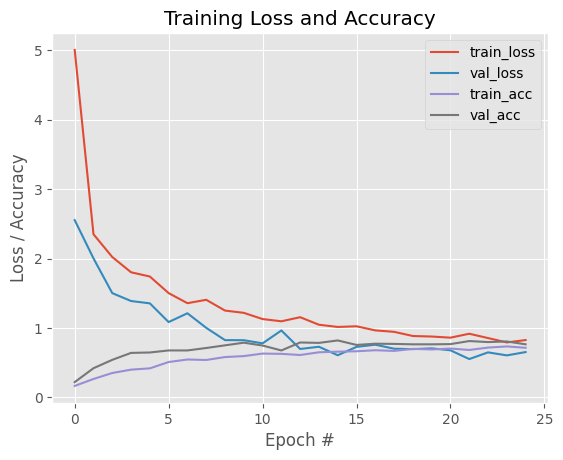

In [15]:
print("[INFO] evaluating after initialization...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=class_names))

plot_training_loss_and_accuracy_keras(
    epoch_num=25,
    H=H
)

In [16]:
# now head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in base_model.layers[15:]:
    layer.trainable = True

# for the changes to the model to take effect we need to recompile
# the model, this time using SGD with a VERY small learning rate
print("[INFO] re-compiling model...")
opt = SGD(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] re-compiling model...


[INFO] fine-tuning model...
Epoch 1/100
32/32 [==============================] - 12s 264ms/step - loss: 0.7090 - accuracy: 0.7471 - val_loss: 0.5289 - val_accuracy: 0.8441
Epoch 2/100
32/32 [==============================] - 7s 228ms/step - loss: 0.5800 - accuracy: 0.7922 - val_loss: 0.5314 - val_accuracy: 0.8412
Epoch 3/100
32/32 [==============================] - 6s 193ms/step - loss: 0.5915 - accuracy: 0.7902 - val_loss: 0.5124 - val_accuracy: 0.8588
Epoch 4/100
32/32 [==============================] - 7s 229ms/step - loss: 0.5858 - accuracy: 0.7971 - val_loss: 0.4500 - val_accuracy: 0.8647
Epoch 5/100
32/32 [==============================] - 6s 195ms/step - loss: 0.5292 - accuracy: 0.8196 - val_loss: 0.5524 - val_accuracy: 0.8206
Epoch 6/100
32/32 [==============================] - 7s 231ms/step - loss: 0.5144 - accuracy: 0.8333 - val_loss: 0.5250 - val_accuracy: 0.8294
Epoch 7/100
32/32 [==============================] - 6s 196ms/step - loss: 0.5297 - accuracy: 0.8118 - val_loss: 

ValueError: ignored

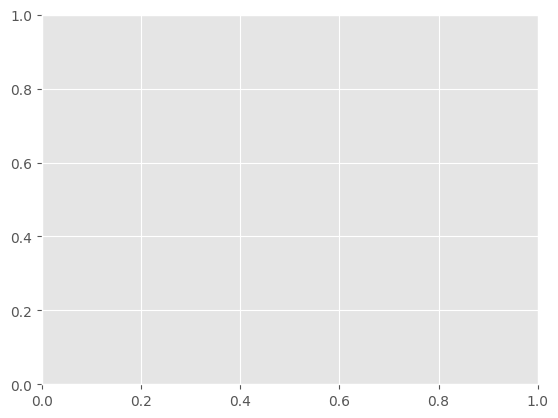

In [17]:
print("[INFO] fine-tuning model...")
H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=32, epochs=100, verbose=1)

print("[INFO] evaluating after fine-tuning...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=class_names))


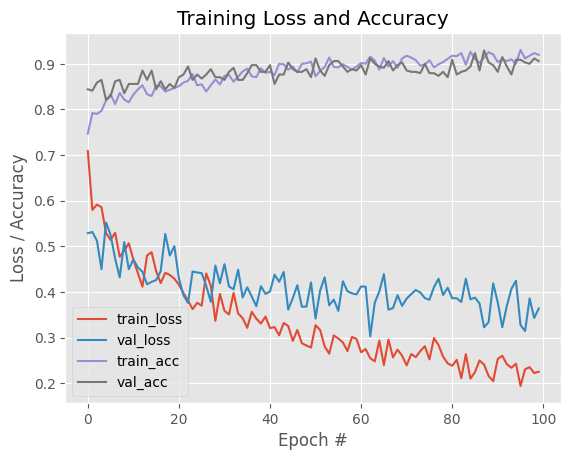

In [18]:
plot_training_loss_and_accuracy_keras(
    epoch_num=100,
    H=H
)